In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

In [4]:
image = tf.Variable(tf.zeros((299, 299, 3)))

In [5]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(image, reuse=False)

In [6]:
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

In [7]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

In [8]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

In [10]:
import json
import matplotlib.pyplot as plt

In [11]:
imagenet_json, _ = urlretrieve(
    'https://gist.githubusercontent.com/cchio/0758cab1239be0bb9042390cbebc5e3f/raw/2950f1e45b783f270dc7d291eac33d4e9cfea3bc/gistfile1.txt')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [12]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Example cat

In [22]:
from PIL import Image
import numpy as np

In [23]:
img_path, _ = urlretrieve('http://www.image-net.org/nodes/10/02123045/6c/6c34fe7c9d846c33a2f1a9b47a766b44ab4ec70d.thumb')
img_class = 281
img = Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

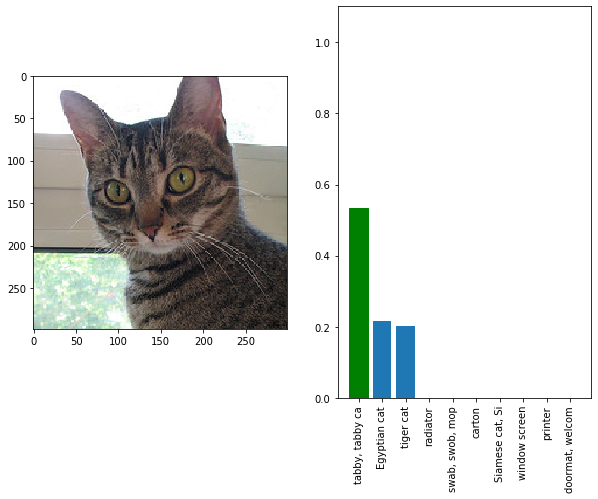

In [24]:
classify(img, correct_class=img_class)

# Adversarial examples

## Initialization

We start with the easiest part: writing a TensorFlow op for initialization.

In [25]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

## Gradient descent step

In [26]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

## Projection step

In [27]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
# clip to [0, 1] to keep it a valid image
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

## Execution

In [28]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

step 10, loss=0.933541
step 20, loss=0.00188102
step 30, loss=0.00110255
step 40, loss=0.000783971
step 50, loss=0.000609093
step 60, loss=0.000497694
step 70, loss=0.000420244
step 80, loss=0.000364476
step 90, loss=0.000322647
step 100, loss=0.000290828


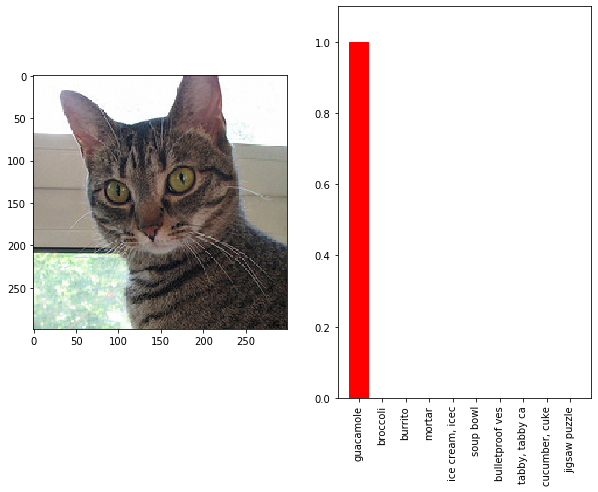

In [29]:
classify(adv, correct_class=img_class, target_class=demo_target)

# Robust adversarial examples

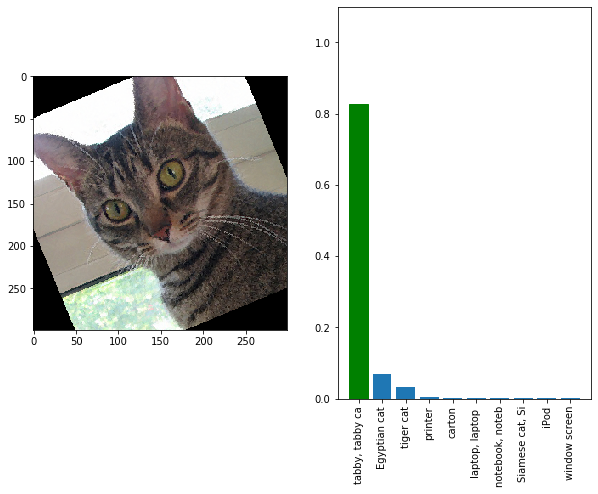

In [30]:
ex_angle = np.pi/8

angle = tf.placeholder(tf.float32, ())
rotated_image = tf.contrib.image.rotate(image, angle)
rotated_example = rotated_image.eval(feed_dict={image: adv, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

In [31]:
num_samples = 10
average_loss = 0
for i in range(num_samples):
    # randomly sample from the distribution and transform their input before classifying it.
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4))
    rotated_logits, _ = inception(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

In [32]:
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss, var_list=[x_hat])

In [33]:
demo_epsilon = 8.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
demo_steps = 300
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example

step 50, loss=0.00282926
step 100, loss=0.00145157
step 150, loss=0.0011544
step 200, loss=0.000937196
step 250, loss=0.000795462
step 300, loss=0.00052464


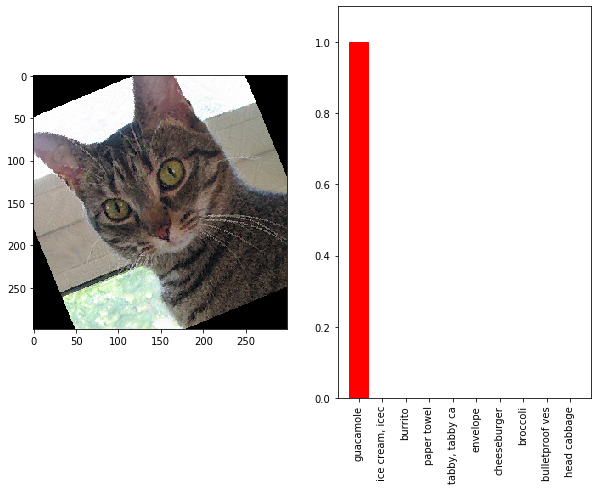

In [34]:
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

## Evaluation

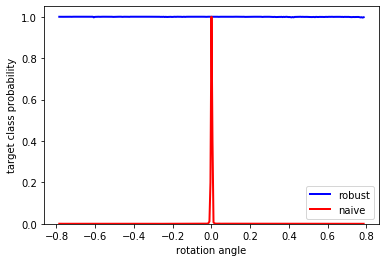

In [35]:
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()